<a href="https://colab.research.google.com/github/justinballas/WorkAutomation/blob/main/BICFR_Subaccount_Rankings_Showcase_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install xlsxwriter

In [5]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter
%matplotlib inline

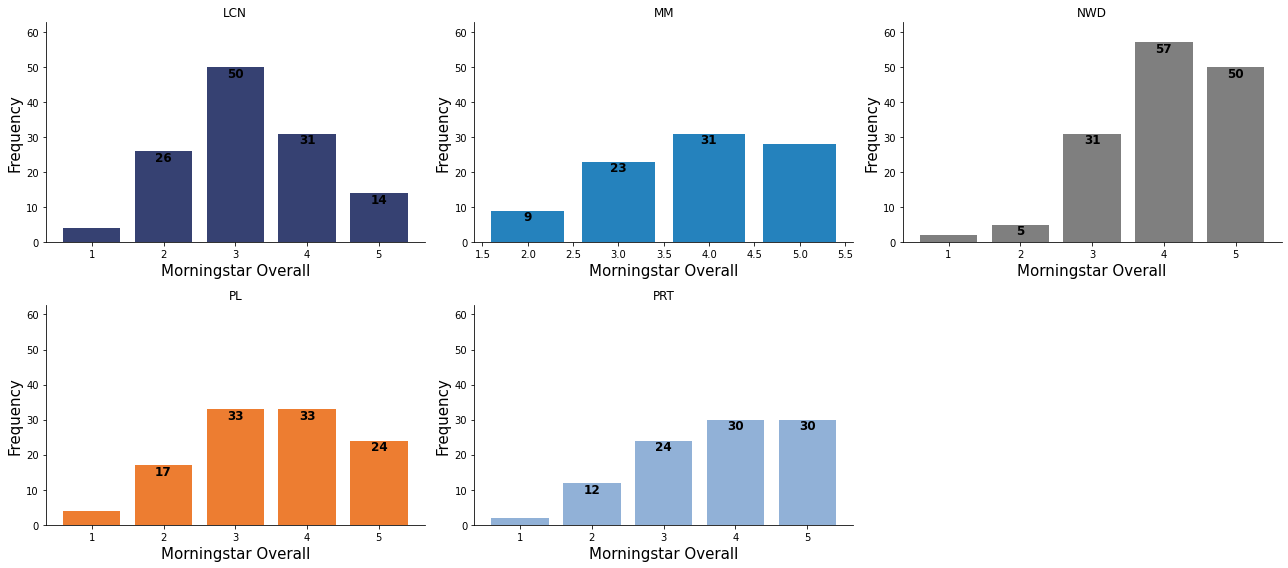

In [15]:
#create a list of carrier aliases that double as the unqiue identifier for file names
carriers_list = ['LCN', 'MM', 'NWD', 'PL', 'PRT']

#create a dictionary of dataframes with the key being the carrier alias
carrier_dfs = {i:pd.read_csv(glob(f'{i}*')[0]) for i in carriers_list}

#assign the appropriate color to each carrier based on MC's color palette
colors_list = ['#364172', '#2582BD', '#7F7F7F', '#ED7D31', '#91B1D7']

#Remove the text wrap anomaly from morningstar output
for carrier, df in carrier_dfs.items():
  df.rename(columns=lambda x: x.replace('\n',''), inplace=True)

#replace_list = ["US Insurance ","US Fund ", "US VUL Sub ", "US VL Sub "]

for carrier in carriers_list:
  temp_df = carrier_dfs[carrier]
  temp_df.drop(temp_df[temp_df['Closed to New Inv']=='Yes'].index, inplace=True)
#  temp_df['Name'] = temp_df['Name'].str.split("-", 1).apply(lambda x: x[1])
#  for phrase in replace_list:
#  temp_df['Morningstar Category'] = temp_df['Morningstar Category'].str.replace(phrase, "")

mnstar_ratings = []
for carrier, df in carrier_dfs.items():
  temp_df = df
  temp_df.insert(loc=0, column='Carrier', value=carrier)
  mnstar_ratings.append(temp_df)

ratings_df = pd.concat(mnstar_ratings)

ratings_df.drop(df[df['Closed to New Inv']=='Yes'].index, inplace=True)

agg_df_carrier = pd.pivot_table(ratings_df, index='Carrier', fill_value=np.nan)

agg_df_class = pd.pivot_table(ratings_df, index='Morningstar Category', fill_value=np.nan)

colors = {carriers_list[i]: colors_list[i] for i in range(len(carriers_list))}

fig = plt.figure(figsize=[18, 8])

def addlabels(x,y):
    for i in range(1, len(x)):
        i = i+1
        plt.text(i, y[i], y[i], ha='center', va='top', fontsize='large', fontweight='bold')

#Creating Hsitogram
#ADD DATA LABELS
ylim = max([carrier_dfs[carrier]['Morningstar Rating Overall'].value_counts().max() for carrier in carriers_list])*1.1
for carrier in enumerate(carrier_dfs.keys()):
  temp_df = ratings_df[ratings_df['Carrier']==carrier[1]]
  temp_df = temp_df[['Morningstar Rating Overall','Carrier']]
  ax = fig.add_subplot(2, 3, carrier[0]+1)
  title = temp_df.iloc[0,1]
  plt.ylim(0, ylim)
  plt.xlabel('Morningstar Overall',fontsize=15)
  plt.ylabel('Frequency',fontsize=15)
  plt.title(title)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  x = temp_df['Morningstar Rating Overall'].value_counts().index
  y = temp_df['Morningstar Rating Overall'].value_counts()
  ax.bar(x, y, color=colors[carrier[1]])
  addlabels(x, np.round(y, 2))
  plt.tight_layout()

plt.savefig('Carrier Histograms.png')


In [ ]:

colors = {colors_list[i]: carriers_list[i] for i in range(len(carriers_list))}

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]/2, y[i], ha = 'center', color='w', fontsize='medium', fontweight='bold')

#Seperating into tables for different sheets
man_tenure = pd.merge(agg_df_carrier['Manager Tenure (Average)'], agg_df_carrier['Manager Tenure (Average)'].rank(ascending=False), how='left', left_index=True, right_index=True,suffixes=('', ' Rank'))
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
bar_colors = colors
data = man_tenure['Manager Tenure (Average)'].sort_values(ascending=False)
x = data.index
y = data.values
ax.bar(x, height=y, color=colors)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Carrier',fontsize=15)
plt.ylabel('Years', fontsize=15)
addlabels(x, np.round(y, 2))
plt.savefig('Manager Tenure')

sharpe = pd.merge(agg_df_carrier['Sharpe Ratio 3 Yr (Mo-End) Risk Currency'], agg_df_carrier['Sharpe Ratio 3 Yr (Mo-End) Risk Currency'].rank(ascending=False), how='left', left_index=True, right_index=True,suffixes=('', ' Rank'))
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
bar_colors = colors
data = sharpe['Sharpe Ratio 3 Yr (Mo-End) Risk Currency'].sort_values(ascending=False)
x = data.index
y = data.values
ax.bar(x, height=y, color=colors)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Carrier',fontsize=15)
plt.ylabel('Sharpe Ratio', fontsize=15)
addlabels(x, np.round(y, 2))
plt.savefig('Sharpe Ratio')

exp_ratio = pd.merge(agg_df_carrier['Prospectus Net Expense Ratio'], agg_df_carrier['Prospectus Net Expense Ratio'].rank(), how='left', left_index=True, right_index=True,suffixes=('', ' Rank'))
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
data = exp_ratio['Prospectus Net Expense Ratio'].sort_values(ascending=False)
x = data.index
y = data.values
ax.bar(x, height=y, color=colors)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Carrier',fontsize=15)
plt.ylabel('Expense Ratio', fontsize=15)
addlabels(x, np.round(y, 2))
plt.savefig('Expense Ratio')

ms_ratings_cols = ['Morningstar Rating 10 Yr', 'Morningstar Rating 5 Yr', 'Morningstar Rating 3 Yr', 'Morningstar Rating Overall']
ms_ratings =  agg_df_carrier[ms_ratings_cols]

#--------------------------------------
for col in ms_ratings_cols:
  ms_ratings["{} Rank".format(col)] = ms_ratings[col].rank(ascending=False)
  
graph_cols = list(ms_ratings.columns[:4])

fig = plt.figure(figsize=(8, 6))

for i in enumerate(graph_cols):
  temp_df = ms_ratings[i[1]].sort_values(ascending=False)
  ax = fig.add_subplot(2, 2, i[0]+1)
  x = temp_df.index
  y = temp_df.values
  plt.xlabel('Carrier',fontsize=15)
  #plt.ylabel('',fontsize=15)
  plt.title(i[1])
  plt.ylim(2.5, 3.6)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.bar(x, y, color=colors)
  addlabels(x, np.round(y, 2))
  plt.tight_layout()

plt.savefig('ms_ratings.png')

#--------------------------------------
rank_cat_cols = ['Total Ret % Rank Cat 1 Yr (Mo-End)', 'Total Ret % Rank Cat 3 Yr (Mo-End)', 'Total Ret % Rank Cat 5 Yr (Mo-End)', 'Total Ret % Rank Cat 10 Yr (Mo-End)']
rank_cat = agg_df_carrier[rank_cat_cols]

for col in rank_cat_cols:
  rank_cat["{} Rank".format(col)] = rank_cat[col].rank()

#--------------------------------------
total_ret_cols = ['Total Ret 1 Yr (Mo-End) Base Currency', 'Total Ret Annlzd 3 Yr (Mo-End) Base Currency', 'Total Ret Annlzd 5 Yr (Mo-End) Base Currency', 'Total Ret Annlzd 10 Yr (Mo-End) Base Currency']
total_ret = agg_df_carrier.loc[:, total_ret_cols]

for col in total_ret_cols:
  total_ret["{} Rank".format(col)] = total_ret[col].rank(ascending=False)

#Best in class fund selection
asset_classes = ratings_df['Morningstar Category'].unique()

ratings_df['sum_ratings'] = ratings_df['Morningstar Rating 10 Yr'] + ratings_df['Morningstar Rating 5 Yr'] + ratings_df['Morningstar Rating 3 Yr'] + ratings_df['Morningstar Rating Overall']

ratings_df['avg_rankings'] = (ratings_df['Total Ret % Rank Cat 1 Yr (Mo-End)'] + ratings_df['Total Ret % Rank Cat 3 Yr (Mo-End)'] + ratings_df['Total Ret % Rank Cat 5 Yr (Mo-End)'] + ratings_df['Total Ret % Rank Cat 10 Yr (Mo-End)'])/4

ratings_df['total_score'] = ratings_df['sum_ratings'] + ratings_df['avg_rankings'].apply(lambda x: 1-(x/100))

bicf_list = []
for carrier in carriers_list:
  temp_df = ratings_df[ratings_df['Carrier']==carrier]
  for asset_class in asset_classes:
    class_df = temp_df[temp_df['Morningstar Category']==asset_class]
    class_df['BICF'] = ['yes' if i == class_df['total_score'].max() else 'no' for i in class_df['total_score']]
    bicf_list.append(class_df)
    
ratings_df = pd.concat(bicf_list)

tables_list = [ms_ratings, rank_cat, total_ret, man_tenure, exp_ratio, sharpe]

for table in tables_list:
  table = table.transpose()

# man_tenure = man_tenure.transpose()
# ms_ratings = ms_ratings.transpose()
# sharpe = sharpe.transpose()
# exp_ratio = exp_ratio.transpose()
# rank_cat = rank_cat.transpose()
# total_ret = total_ret.transpose()

#writing to excel
xlwriter = pd.ExcelWriter('Subaccount Rankings Python Output.xlsx', engine='xlsxwriter')

man_tenure.to_excel(xlwriter, sheet_name='Manager Tenure')
xlwriter.sheets['Manager Tenure'].insert_image('D10', 'Manager Tenure.png')

ms_ratings.to_excel(xlwriter, sheet_name='Ratings')
xlwriter.sheets['Ratings'].insert_image('D10', 'ms_ratings.png')

sharpe.to_excel(xlwriter, sheet_name='Sharpe Ratio')
xlwriter.sheets['Sharpe Ratio'].insert_image('D10', 'Sharpe Ratio.png')

exp_ratio.to_excel(xlwriter, sheet_name='Expense Ratio')
xlwriter.sheets['Expense Ratio'].insert_image('D10', 'Expense Ratio.png')

rank_cat.to_excel(xlwriter, sheet_name='Return Rankings')
total_ret.to_excel(xlwriter, sheet_name='Total Return')

agg_df_class.to_excel(xlwriter, sheet_name='Asset Class Breakdown')

bicf_df = ratings_df[ratings_df['BICF']=='yes']
bicf_df.set_index(['Carrier','Morningstar Category'], inplace=True)
bicf_df.to_excel(xlwriter, sheet_name='BICFR')

ratings_df.set_index(['Carrier', 'Name'], inplace=True)
ratings_df.to_excel(xlwriter, sheet_name='All Data')

empty_sheet = pd.DataFrame()
empty_sheet.to_excel(xlwriter, sheet_name='Histogram')
worksheet=xlwriter.sheets['Histogram']
worksheet.insert_image('B2','Carrier Histograms.png')

counter = 0
for i in range(len(carriers_list)):
  list(carrier_dfs.values())[i].to_excel(xlwriter, sheet_name='{}'.format(carriers_list[i]))

xlwriter.save()

xlwriter.close()